# EMT Simulation of topology with slack, line and VSI

In [1]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import matplotlib.pyplot as plt
import re
import dpsimpy

# %matplotlib widget

ModuleNotFoundError: No module named 'dpsimpy'

## EMT Simulation

### Parametrization

In [ ]:
final_time = 1
time_step = 0.1e-3
sim_name = "EMT_Slack_PiLine_VSI_with_PF_Init"
pv_with_control = True
cmd_scale_P = 1.0
cmd_scale_I = 1.0
V_nom = 20e3

### Powerflow for Initialization

In [ ]:
time_step_pf = final_time
final_time_pf = final_time + time_step_pf
sim_name_pf = sim_name + "_PF"
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# Components
n1_pf = dpsimpy.sp.SimNode('n1', dpsimpy.PhaseType.Single)
n2_pf = dpsimpy.sp.SimNode('n2', dpsimpy.PhaseType.Single)

extnet_pf = dpsimpy.sp.ph1.NetworkInjection('Slack', dpsimpy.LogLevel.debug)
extnet_pf.set_parameters(voltage_set_point=V_nom)
extnet_pf.set_base_voltage(V_nom)
extnet_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

line_pf = dpsimpy.sp.ph1.PiLine('PiLine', dpsimpy.LogLevel.debug)
line_pf.set_parameters(R=0.5*5, L=0.5/314*5, C=50e-6/314*5)
line_pf.set_base_voltage(V_nom)

load_pf = dpsimpy.sp.ph1.Load('Load', dpsimpy.LogLevel.debug)
load_pf.set_parameters(active_power=-100e3, reactive_power=-50e3, nominal_voltage=20e3)
load_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.PQ)

# Topology
extnet_pf.connect([n1_pf])
line_pf.connect([n1_pf, n2_pf])
load_pf.connect([n2_pf])
system_pf = dpsimpy.SystemTopology(50, [n1_pf, n2_pf], [extnet_pf, line_pf, load_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute('v1', 'v', n1_pf)
logger_pf.log_attribute('v2', 'v', n2_pf)

# Simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(time_step_pf)
sim_pf.set_final_time(final_time_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[14:06:06.300350 PiLine warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[14:06:06.329281 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Initialize simulation: EMT_Slack_PiLine_VSI_with_PF_Init_PF
[14:06:06.333162 EMT_Slack_PiLine_VSI_with_PF_Init_PF_PF_Solver warning] No suitable quantity found for setting mBaseApparentPower. Using 100000000 VA.
[14:06:06.336100 EMT_Slack_PiLine_VSI_with_PF_Init_PF_PF_Solver warning] Unable to get base voltage at n1
[14:06:06.337101 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Scheduling tasks.
[14:06:06.340573 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Scheduling done.
[14:06:06.340577 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Opening interfaces.
[14:06:06.340580 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Start synchronization with remotes on 0 interfaces
[14:06:06.340581 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Synchronized simulation start with remotes
[14:06:06.340584 EMT_Slack_PiLine_VSI_with_PF_Init_PF info] Start simulatio

### Dynamic Simulation

In [ ]:
time_step_emt = time_step
final_time_emt = final_time + time_step_emt
sim_name_emt = sim_name + "_EMT"
dpsimpy.Logger.set_log_dir('logs/' + sim_name_emt)

# Components
gnd = dpsimpy.emt.SimNode.gnd
n1_emt = dpsimpy.emt.SimNode('n1', dpsimpy.PhaseType.ABC)
n2_emt = dpsimpy.emt.SimNode('n2', dpsimpy.PhaseType.ABC)

extnet_emt = dpsimpy.emt.ph3.NetworkInjection('Slack', dpsimpy.LogLevel.debug)

line_emt = dpsimpy.emt.ph3.PiLine('PiLine', dpsimpy.LogLevel.debug)
line_emt.set_parameters(
    series_resistance=dpsimpy.Math.single_phase_parameter_to_three_phase(0.5*5),
    series_inductance=dpsimpy.Math.single_phase_parameter_to_three_phase((0.5/314)*5),
    parallel_capacitance=dpsimpy.Math.single_phase_parameter_to_three_phase((50e-6/314)*5))

pv = dpsimpy.emt.ph3.AvVoltageSourceInverterDQ("pv", "pv", dpsimpy.LogLevel.debug, with_trafo=True)
pv.set_parameters(sys_omega=2 * np.pi * 50, sys_volt_nom=V_nom, p_ref=100e3, q_ref=50e3)
pv.set_controller_parameters(Kp_pll=cmd_scale_P * 0.25, Ki_pll=cmd_scale_I * 0.2,
                             Kp_power_ctrl=cmd_scale_P *0.001, Ki_power_ctrl=cmd_scale_I * 0.008 ,
                             Kp_curr_ctrl=cmd_scale_P * 0.3, Ki_curr_ctrl=cmd_scale_I * 1, omega_cutoff=2*np.pi*50)
pv.set_filter_parameters(Lf=0.002,Cf=789.3e-6,Rf=0.1,Rc=0.1)
pv.set_transformer_parameters(nom_voltage_end_1=V_nom, nom_voltage_end_2=1500, rated_power=5e6,
                              ratio_abs=V_nom / 1500, ratio_phase=0,resistance=0, inductance=0.928e-3,
                              omega=2 * np.pi * 50)
pv.set_initial_state_values(p_init=100e3, q_init=50e3, phi_d_init=0, phi_q_init=0, gamma_d_init=0, gamma_q_init=0)
pv.with_control(pv_with_control)

# Topology
extnet_emt.connect([n1_emt])
line_emt.connect([n1_emt, n2_emt])
pv.connect([n2_emt])
system_emt = dpsimpy.SystemTopology(50, [n1_emt, n2_emt], [extnet_emt, line_emt, pv])

# Initialization of dynamic topology
system_emt.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)

# Logging
logger_emt = dpsimpy.Logger(sim_name_emt)
logger_emt.log_attribute('v1', 'v', n1_emt)
logger_emt.log_attribute('v2', 'v', n2_emt)
logger_emt.log_attribute('i12', 'i_intf', line_emt)


input_names = [
    "pv_powerctrl_input_pref", "pv_powerctrl_input_qref", "pv_powerctrl_input_vcd",
    "pv_powerctrl_input_vcq", "pv_powerctrl_input_ircd", "pv_powerctrl_input_ircq"
]
logger_emt.log_attribute(input_names, 'powerctrl_inputs', pv)

state_names = [
    "pv_powerctrl_state_p", "pv_powerctrl_state_q", "pv_powerctrl_state_phid",
    "pv_powerctrl_state_phiq", "pv_powerctrl_state_gammad", "pv_powerctrl_state_gammaq"
]
logger_emt.log_attribute(state_names, 'powerctrl_states', pv)

output_names = [
    "pv_powerctrl_output_vsd", "pv_powerctrl_output_vsq"
]

logger_emt.log_attribute(output_names, 'powerctrl_outputs', pv)

logger_emt.log_attribute('pv_v_intf', 'v_intf', pv)
logger_emt.log_attribute('pv_i_intf', 'i_intf', pv)
logger_emt.log_attribute('pv_pll_output', 'pll_output', pv)
logger_emt.log_attribute('pv_vsref', 'Vsref', pv)
logger_emt.log_attribute('pv_vs', 'Vs', pv)

# load step sized in absolute terms
load_switch = dpsimpy.emt.ph3.Switch("Load_Add_Switch_n2", dpsimpy.LogLevel.debug)
connection_node = system_emt.node('n2')
resistance = np.abs(connection_node.initial_single_voltage())**2 / 10e6
load_switch.set_parameters(np.identity(3) * 1e9, np.identity(3) * resistance)
load_switch.open()
system_emt.add(load_switch)
system_emt.connect_component(load_switch, [gnd, system_emt.node('n2')])
logger_emt.log_attribute('switchedload_i', 'i_intf', load_switch)
load_step_event = dpsimpy.event.SwitchEvent3Ph(np.round(5.0/time_step)*time_step, load_switch, True)

# Simulation
sim_emt = dpsimpy.Simulation(sim_name_emt, dpsimpy.LogLevel.debug)
sim_emt.set_system(system_emt)
sim_emt.set_time_step(time_step_emt)
sim_emt.set_final_time(final_time_emt)
sim_emt.set_domain(dpsimpy.Domain.EMT)
sim_emt.add_event(load_step_event)
sim_emt.add_logger(logger_emt)
sim_emt.run()

[14:06:08.905836 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Initialize simulation: EMT_Slack_PiLine_VSI_with_PF_Init_EMT
[14:06:08.910885 MnaSolverFactory info] creating EigenDense solver implementation
[14:06:08.992308 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Scheduling tasks.
[14:06:08.995917 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Scheduling done.
[14:06:08.995921 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Opening interfaces.
[14:06:08.995925 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Start synchronization with remotes on 0 interfaces
[14:06:08.995926 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Synchronized simulation start with remotes
[14:06:08.995928 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Start simulation: EMT_Slack_PiLine_VSI_with_PF_Init_EMT
[14:06:08.995932 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Time step: 1.000000e-04
[14:06:08.995933 EMT_Slack_PiLine_VSI_with_PF_Init_EMT info] Final time: 1.000100e+00
[14:06:17.400348 EMT_Slack_PiLine_VSI_with_PF_Init_EMT

## PF results

In [ ]:
modelName = 'EMT_Slack_PiLine_VSI_with_PF_Init_PF'
path = 'logs/' + modelName + '/'
dpsim_result_file = path + modelName + '.csv'

ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

column number: 2
results length: 2
real column names: []
complex column names: ['v1', 'v2']


## EMT results

In [ ]:
modelName = 'EMT_Slack_PiLine_VSI_with_PF_Init_EMT'
path = 'logs/' + modelName + '/'
dpsim_result_file = path + modelName + '.csv'
PEAK1PH_TO_RMS3PH = np.sqrt(3.0/2.0)
ts_dpsim = read_timeseries_csv(dpsim_result_file)

column number: 38
results length: 10002
real column names: ['i12_0', 'i12_1', 'i12_2', 'pv_i_intf_0', 'pv_i_intf_1', 'pv_i_intf_2', 'pv_pll_output_0', 'pv_pll_output_1', 'pv_powerctrl_input_ircd', 'pv_powerctrl_input_ircq', 'pv_powerctrl_input_pref', 'pv_powerctrl_input_qref', 'pv_powerctrl_input_vcd', 'pv_powerctrl_input_vcq', 'pv_powerctrl_output_vsd', 'pv_powerctrl_output_vsq', 'pv_powerctrl_state_gammad', 'pv_powerctrl_state_gammaq', 'pv_powerctrl_state_p', 'pv_powerctrl_state_phid', 'pv_powerctrl_state_phiq', 'pv_powerctrl_state_q', 'pv_v_intf_0', 'pv_v_intf_1', 'pv_v_intf_2', 'pv_vs_0', 'pv_vs_1', 'pv_vs_2', 'pv_vsref_0', 'pv_vsref_1', 'pv_vsref_2', 'switchedload_i', 'v1_0', 'v1_1', 'v1_2', 'v2_0', 'v2_1', 'v2_2']
complex column names: []


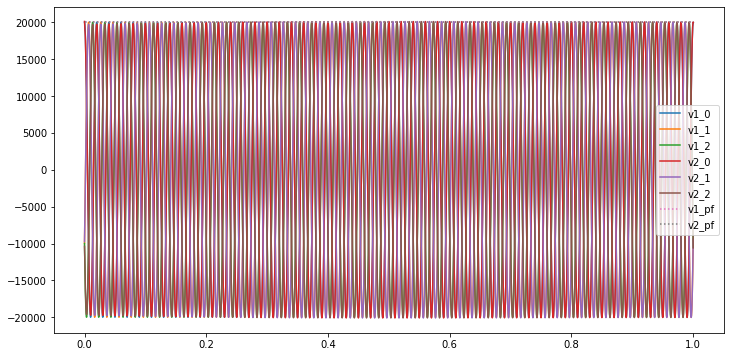

In [ ]:
plt.figure(figsize=(12,6))
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['v1_0','v1_1','v1_2','v2_0','v2_1','v2_2']:
        plt.plot(ts_obj.time, PEAK1PH_TO_RMS3PH*ts_obj.values, label=ts_name)
for ts_name, ts_obj  in ts_dpsim_pf.items():
        plt.plot(ts_obj.time, ts_obj.abs().values, label=ts_name+'_pf', linestyle=':')
plt.legend()
plt.show()

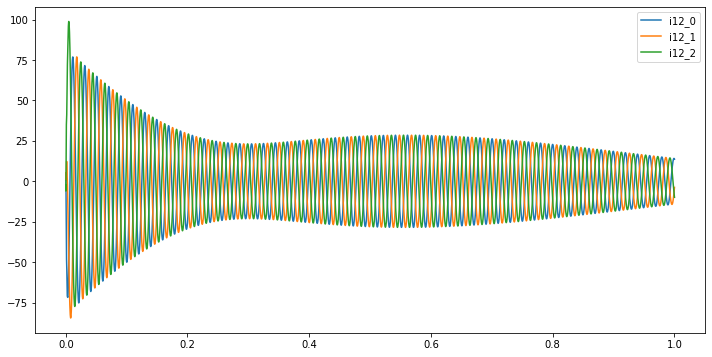

In [ ]:
plt.figure(figsize=(12,6))
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['i12_0','i12_1','i12_2']:
        plt.plot(ts_obj.time, PEAK1PH_TO_RMS3PH*ts_obj.values, label=ts_name)

plt.legend()
plt.show()

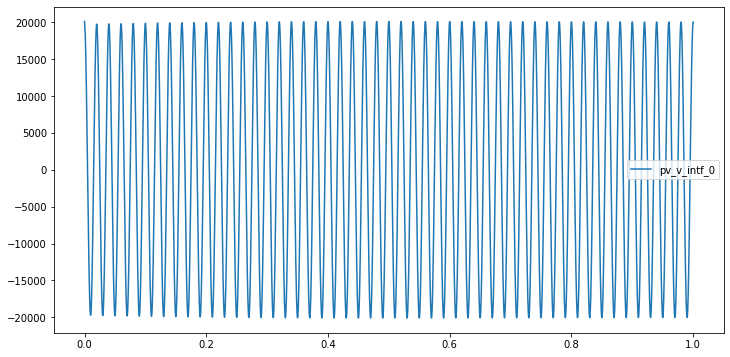

In [ ]:
plt.figure(figsize=(12,6))
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['pv_v_intf_0']:
        plt.plot(ts_obj.time, PEAK1PH_TO_RMS3PH*ts_obj.values, label=ts_name)

plt.legend()
plt.show()

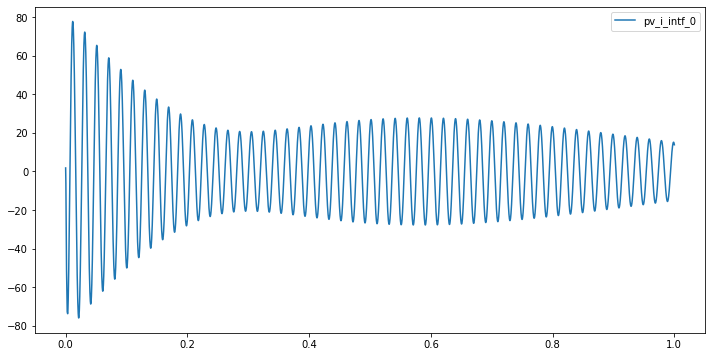

In [ ]:
plt.figure(figsize=(12,6))
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['pv_i_intf_0']:
        plt.plot(ts_obj.time, PEAK1PH_TO_RMS3PH*ts_obj.values, label=ts_name)

plt.legend()
plt.show()